# LSTM을 이용한 비트코인 시계열 예측

### 필요 라이브러리 import

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
# 데이터 읽기
data = pd.read_csv(filepath_or_buffer="./source/BTCUSDKRAKEN", index_col="Date")

In [3]:
# 데이터 정보 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1380 entries, 2014-01-07 to 2017-10-17
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               1380 non-null   float64
 1   High               1380 non-null   float64
 2   Low                1380 non-null   float64
 3   Close              1380 non-null   float64
 4   Volume (BTC)       1380 non-null   float64
 5   Volume (Currency)  1380 non-null   float64
 6   Weighted Price     1380 non-null   float64
dtypes: float64(7)
memory usage: 86.2+ KB


In [4]:
# 데이터 앞부분 보기
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [5]:
# Weighted Price를 기준으로 그래프 그리기
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

In [6]:
# 0값이거나 NAN인 데이터를 ffill을 통해 채우기
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

In [7]:
# 새로 채워진 값으로 그래프 다시 그리기
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

In [8]:
# Weighted Price가 LSTM 모델의 특징으로 사용
# MinMaxScaler을 통해 Weighted Price를 0과 1 사이의 범위로 일반화
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [9]:
# 데이터의 70%만 학습, 30%는 테스트
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

965 415


In [10]:
# 데이터셋을 만들기 위한 함수
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [11]:
# 데이터셋 생성
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

964
414


In [12]:
# 모델 학습을 위해 X reshape
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
# 300 epochs로 LSTM 모델 학습
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

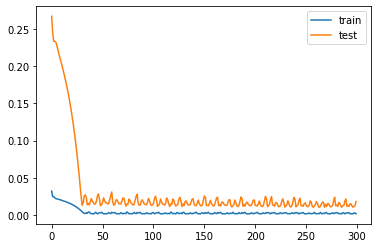

In [14]:
# 학습 데이터의 loss값, 테스트 셋의 loss값 그래프
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

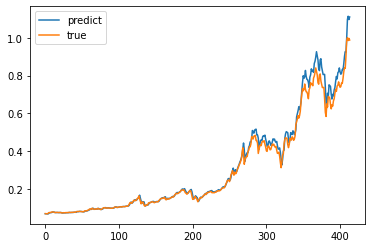

In [15]:
# textX를 사용해 예측모델
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [16]:
# Y를 inverse하여 일반값
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [17]:
# RMSE
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 181.672


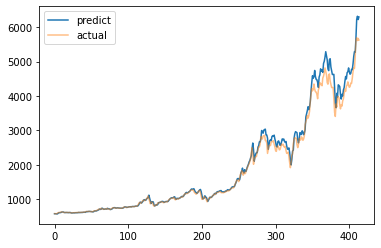

In [18]:
# Y를 USD로 그래프 그리기
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [19]:
# 데이터를 x로 변환
predictDates = data.tail(len(testX)).index

In [21]:
# testY와 yhat을 reshape
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [22]:
# x는 데이터, y는 USD로 하여 실제 그래프와 예측 그래프 생성
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])